# Introduction into Series

Expanding the dimensional horizon. In the previous classification examples we always fed the transactions one-by-one, meaning we show the model exactly 1 transaction with a label and ask the model to classify the transaction. That is very much how traditional Machine Learning works. Each training sample is like a 1-dimensional vector with the various features as columns. 

The disadvantage of feeding just one transaction is that the model has zero context on the card, customer or merchant. It does not know anything about the previous transactions or the overall historical behaviour of the card, the customer or the merchant. In real life that very much limits the model's ability to find fraud efficiently. In traditional machine learning this challenge is tackled by feature engineering, for instance adding aggregate features, say the 6-month average per card to the transaction record. Though this adds context, it still very much sticks to a 2-dimensional approach (one-transaction-at-a-time).

With Neural Nets, the training records can be multi-dimensional. The data records are often called `Tensors`
with a `Rank`, where the rank is the number of dimensions. Traditional machine learning mainly uses rank-2 input. With the rows being the transactions (samples) and the columns being the features for the transactions. Deep Learning basically has as many ranks as you want.

Looking at how this can work for our Fraud examples, one thing we could do is *not* just give the model 1 transaction and 1 label at a time but giving it multiple transactions and 1 label. For instance the last 10 transactions and the label of the last of the 10 transactions. Those can be stacked so we get a 2-dimensional record with the **#Payments** (from P-9 till P) being the **width** of that record and the **Features** being the **depth/heigth**. This structure contains 10 transactions each with their features. The Position lines up with the columns, each column now has all the features of a transaction at a specific Position. But the time is relative, for 2 different samples of (SxF), the absolute time could be different.

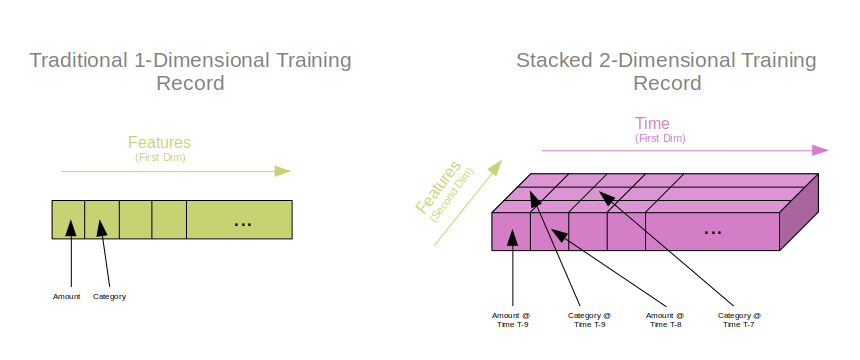

A series provides the model with some historical context on the `Series Key`, which could be the card, account, merchant etc... We would hope this helps the model look beyond just a single transaction, and achieve better results.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import datetime as dt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../data/bs140513_032310.csv'

## Define Base Features

As compared to the previous notebooks two additional fields from the input are used.

- The step field, in the output we can see it is an increasing integer number. It can loosly be interpreted as a time-step.
- The customer identifier. We'll see if this is useful as a series key. We are using the string type here rather than categorical because the values have high cardinality.


In [5]:
# Base Features
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

The **step** field in not all that useful, we would rather have a real date. We can convert the step field using a `FeatureExpression`, they allow us to run free-form expressions. We give it a name, a type, tell it the function to call and the parameter features to feed it. Here we assume the step is a day and add it as delta to 2020/01/01.

In [6]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

## Are there series in this data?
In a standard card fraud data set we would probably assume that the `Card` is a good candidate for a series key, i.e. the entity on which we provide context. In this data set however it is far from clear this approach would make sense. It might, if the data is constructed so that each customer has a standard behaviour and when they do something irregular, that those are the fraud. There is not a lot of evidence of that is the case.

If anything the fraud seems to be grouped in pairs per each merchant, we see groups of 2 frauds in a specific timestep. It feels like we might be better of grouping on the `Merchant` key.


In [7]:
td_all = ft.TensorDefinition('td_all', [
    date_time, customer, amount, age, gender, merchant, category, fraud
])

with en.EnginePandas() as e:
    df = e.df_from_csv(td_all, file, inference=False)

2023-06-12 11:08:21.238 eng1n3.common.engine           INFO     Start Engine...
2023-06-12 11:08:21.239 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-12 11:08:21.239 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-12 11:08:21.246 eng1n3.pandas.pandasengine     INFO     Building Panda for : td_all from file ../../../../data/bs140513_032310.csv
2023-06-12 11:08:21.827 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: td_all


In [8]:
df[df['fraud'] == 1]

,date,customer,amount,age,gender,merchant,category,fraud
88,2020-01-01,C583110837,44.26,3,M,M480139044,es_health,1
89,2020-01-01,C1332295774,324.50,3,M,M480139044,es_health,1
434,2020-01-01,C1160421902,176.32,3,M,M857378720,es_hotelservices,1
435,2020-01-01,C966214713,337.41,3,M,M857378720,es_hotelservices,1
553,2020-01-01,C1450140987,220.11,4,F,M1198415165,es_wellnessandbeauty,1
...,...,...,...,...,...,...,...,...
593928,2020-06-28,C2138532527,192.78,5,M,M3697346,es_leisure,1
594025,2020-06-28,C644541754,42.37,5,F,M1748431652,es_wellnessandbeauty,1
594026,2020-06-28,C245117318,521.84,3,F,M1748431652,es_wellnessandbeauty,1
594168,2020-06-28,C1239184141,25.29,2,F,M209847108,es_wellnessandbeauty,1


In [9]:
# Categorical Features
amount_bin = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 25, scale_type='geometric')
age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
# Label Feature
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

td_all = ft.TensorDefinition('td_all', [
    date_time, customer, amount_bin, age_i, gender_i, merchant_i, category_i, fraud_label
])

## Derived Features

In [10]:
# Categorical Features
amount_bin = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 25, scale_type='geometric')
age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
# Label Feature
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

td_all = ft.TensorDefinition('td_all', [
    date_time, merchant, amount_bin, age_i, gender_i, category_i, fraud_label
])

with en.EnginePandas() as e:
    df = e.df_from_csv(td_all, file, inference=False)

2023-06-12 11:08:28.674 eng1n3.common.engine           INFO     Start Engine...
2023-06-12 11:08:28.674 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-12 11:08:28.675 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-12 11:08:28.675 eng1n3.pandas.pandasengine     INFO     Building Panda for : td_all from file ../../../../data/bs140513_032310.csv
2023-06-12 11:08:29.255 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: td_all


In [11]:
df

,date,merchant,amount_bin,age_index,gender_index,category_index,fraud_label
0,2020-01-01,M348934600,9,1,1,1,0
1,2020-01-01,M348934600,13,2,1,1,0
2,2020-01-01,M1823072687,12,1,2,1,0
3,2020-01-01,M348934600,11,3,1,1,0
4,2020-01-01,M348934600,13,4,1,1,0
...,...,...,...,...,...,...,...
594638,2020-06-28,M1823072687,12,3,2,1,0
594639,2020-06-28,M1823072687,14,1,2,1,0
594640,2020-06-28,M349281107,12,2,2,11,0
594641,2020-06-28,M1823072687,11,4,1,1,0


## Build Series
At this point we have more or less the same set-up as the example for the FeedForward classifier, execpt that there is a date. With this new feature and the merchant-id we can build a **stacked series** from our data.

We do this by defining a `FeatureSeriesStacked`, we provide the feature definition a list of features we want to include in the series, the length of the series *(10)* and they key *(merchant)* we want to use.

That will create a sort of sliding window of 10 on the transactions of each merchant. It will return the transactions as a rank-3 tensor. The tensor will have the batch as first dimension, the series length as second dimension the features as third dimension. We will denote it as a **(BxSxF)** tensor.

In the call to the `np_from_csv` we also need to provide a feature we will use as time. That is provided via the `time_feature` parameter.

In [12]:
# Create a stacked series of length 10 using the merchant feature as key.
stacked_series = ft.FeatureSeriesStacked(
    'stacked', ft.FEATURE_TYPE_INT_16, [amount_bin, age_i, gender_i, merchant_i, category_i], 10, merchant
)

td_series = ft.TensorDefinition('stacked', [stacked_series])
td_label = ft.TensorDefinition('label', [fraud_label])

# Note we 
with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_series, td_label), file, time_feature=date_time, inference=False)

2023-06-12 11:08:43.958 eng1n3.common.engine           INFO     Start Engine...
2023-06-12 11:08:43.959 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-12 11:08:43.959 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-12 11:08:43.960 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/bs140513_032310.csv
2023-06-12 11:08:44.543 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-12 11:08:44.546 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked using 1 process(es)
2023-06-12 11:08:45.116 e...ureseriesstackedprocessor  INFO     Returning series of type int16.
2023-06-12 11:08:45.117 e...ureseriesstackedprocessor  INFO     Series Shape=[(-1, 10, 5)]


In [13]:
ti

TensorInstance with shapes: ((594643, 10, 5), (594643, 1))

## A use case

Its easiest to understand what these series do by looking at an example. Let us look at one specific merchant and their transactions. This merchant had 2428 transactions on the 1st of January.

Let's maybe take the example of the 6th transaction. It has an **index of 5** in the dataframe.

In [14]:
df[(df['merchant'] == 'M348934600') & (df['date'] == dt.datetime(2020,1 ,1))]

,date,merchant,amount_bin,age_index,gender_index,category_index,fraud_label
0,2020-01-01,M348934600,9,1,1,1,0
1,2020-01-01,M348934600,13,2,1,1,0
3,2020-01-01,M348934600,11,3,1,1,0
4,2020-01-01,M348934600,13,4,1,1,0
5,2020-01-01,M348934600,12,3,2,1,0
...,...,...,...,...,...,...,...
2423,2020-01-01,M348934600,11,2,1,1,0
2424,2020-01-01,M348934600,14,2,2,1,0
2426,2020-01-01,M348934600,12,5,2,1,0
2427,2020-01-01,M348934600,13,2,2,1,0


If we look up the index **5** in the series we are getting back a **single training sample** with a shape of `1x10x5`.
- 1 is the batch dimension, because are selecting a single training sample.
- 10 is the series dimension, because we asked the engine to stack 10 transactions.
- 5 is the feature dimension, because the `FeatureSeriesStacked` feature had 5 'embedded' features.

So here one training sample is not just a one dimensional set of features. Each training sample is now 2 dimensional and contains the transaction at entry **5** + the 9 payments preceding the payment for that merchant. The first 5 rows are padded with zeros because there is no history before the 1st of January.

In [15]:
dl=ti[5]
print(dl.numpy_lists[0].shape)
print(dl.numpy_lists[0])

(1, 10, 5)
[[[ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 0  0  0  0  0]
  [ 9  1  1  1  1]
  [13  2  1  1  1]
  [11  3  1  1  1]
  [13  4  1  1  1]
  [12  3  2  1  1]]]


When it is trained our neural net will get this sample + the label whether or not that series of transactions is a fraud or not. Or we can think of it as saying; whether or not the last transaction is a fraud given that last transaction + the 9 transactions of the same merchant preceeding the last transaction.

In [16]:
print(dl.numpy_lists[1])

[[0]]


## Challenge

If we want to use this in a FeedForward Neural Net, we see we have a small challenge. The `Linear Layers` are designed to have a rank-1 tensor as input. I.e. a vector. Here we have an array we would like to input, we could flatten the array out by stacking either the time or feature elements one after another, like depicted below. This operation is named Flatten operation.

Though that would most certainly create a Neural Net that sees and can evaluate more than one payment at a time, intuitively we could argue that this is fairly likely to focus on very specific patterns, such as a amounts at T-9 with Categories at T-4. That this model might overfit and not generalize the way we would like it to. (More on over-fitting later on....) Also the Time-axis is sort of lost, the model is just free to combine any time with any other time.

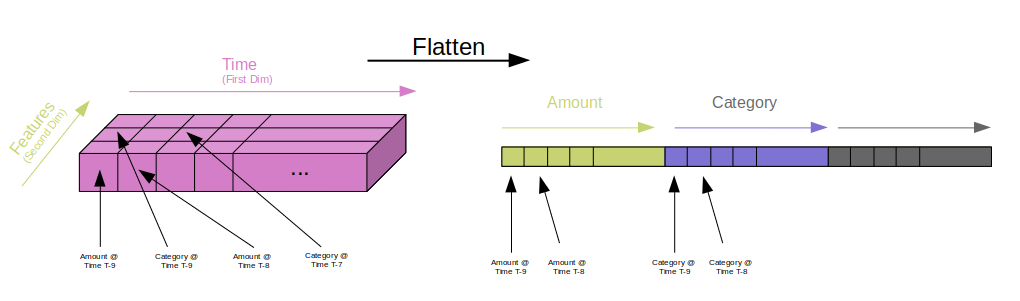

Luckily, there are specific NN architectures such as `Recurrent (RNN)`, `Convolutional Layers (CNN)` and `Transformers` specifically designed to handle the sort of multi-dimensional data we created in the series.

## Note on Redundancy

Examining the previous example we can spot some redundancy, the **category and merchant** are always the same at each position within the series, regardless of the payment. They are referential information linked to the merchant, not to the payment. Repeating it in the series might not harm the model, but we could argue that it is a bit wasteful on memory and resources. 

This can easily be fixed by defining a seperate `TensorDefinition` for the referential data. Like below;

In [17]:
stacked_series = ft.FeatureSeriesStacked(
    'stacked', ft.FEATURE_TYPE_INT_16, [amount_bin, age_i, gender_i], 10, merchant
)

td_referential = ft.TensorDefinition('referential', [merchant_i, category_i])
td_series      = ft.TensorDefinition('stacked', [stacked_series])
td_label       = ft.TensorDefinition('label', [fraud_label])

# Note we 
with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_referential, td_series, td_label), file, time_feature=date_time, inference=False)

2023-06-12 11:10:17.833 eng1n3.common.engine           INFO     Start Engine...
2023-06-12 11:10:17.835 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-12 11:10:17.836 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-12 11:10:17.837 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/bs140513_032310.csv
2023-06-12 11:10:18.429 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-12 11:10:18.432 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked using 1 process(es)
2023-06-12 11:10:18.496 e...ureseriesstackedprocessor  INFO     Returning series of type int16.
2023-06-12 11:10:18.497 e...ureseriesstackedprocessor  INFO     Series Shape=[(-1, 10, 3)]


Which gives us a multi-head input. Each training sample now consists of;
- a 1x2 tensor with the id category code and of the merchant
- a 1x10x3 tensor with the binned amount, the age and gender of the customer of the 10 last payments.
- a 1x1 tensor with the label, in this case showing a non-fraud.

In [18]:
dl=ti[5]
print(dl.numpy_lists[0])
print(dl.numpy_lists[1])
print(dl.numpy_lists[2])

[[1 1]]
[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 9  1  1]
  [13  2  1]
  [11  3  1]
  [13  4  1]
  [12  3  2]]]
[[0]]


# Conclusion
In this notebook the data-structure was introduced that will be used in the next examples. It is a multi-dimensional structure where the time and feature are on different axis.

What is not so sure, is if this will actually help our model. It's not really clear if this data contains useful sequences. It may turn out that the examples are more illustrative than useful.